In [ ]:
%pip install seaborn[stats]

# UWF* datasets stats

This notebook explores the data from the UWF22 dataset

In this notebook, we explore:
- Basic dataset stats


### Prepare the dataset

Run the preparation for the dataset with the `prepare_data` and `setup` methods.

In [2]:
from datasets.UWF22_local import UWF22L
from datasets.UWF22H_local import UWF22HL
from datasets.UWF22Fall_local import UWF22FallL
from datasets.UWF24_local import UWF24L
from datasets.UWF24Fall_local import UWF24FallL
from ordered_set import OrderedSet

possible_datasets = ["UWF22", "UWF22h", "UWF22Fall", "UWF24", "UWF24Fall"]

/home/t/Desktop/Projects/MSc-Thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

class KeyMapGen():
    # Exclude the mapping for the following columns
    exclude_columns = [
        "ts",
        "src_ip_id",
        "src_ip_zeek",
        "dest_ip_id",
        "dest_ip_zeek",
        "src_service_id",
        "dest_service_id"
    ]

    def __init__(self, dataset, output_folder) -> None:
        self.dataset = dataset
        self.output_folder = output_folder
        self.key_file = os.path.join(self.output_folder, f"{dataset.dataset_name}_keywordmap_percent.parquet")
        self.first_batch_passed = False

    def generate_maps(self, columns):

        self.keyword_map = {col: OrderedSet([]) for col in columns if col not in self.exclude_columns}
        self.hostmap = OrderedSet([])
        self.usermap = OrderedSet([])

        # Keep track of the added values per column
        self.added_items_per_bin = {col: [] for col in columns if col not in self.exclude_columns}
        self.added_items_per_bin["hosts"] = []
        self.added_items_per_bin["services"] = []
        self.added_items_per_bin["stage"] = []

    def count_updates(self, ordered_set: OrderedSet, update):
        set_size = len(ordered_set)
        ordered_set.update(update)
        new_size = len(ordered_set)
        return new_size - set_size

    def process_batch(self, batch, stage):
        # If this is the first batch, generate the maps as well
        if not self.first_batch_passed:
            columns = list(batch[0].columns)
            self.generate_maps(columns)
            self.first_batch_passed = True

        # Go trough every bin
        for bin in batch:
            # Update keyword map
            for col in self.keyword_map.keys():
                diff = self.count_updates(self.keyword_map[col], bin[col].dropna().unique())
                self.added_items_per_bin[col].append(diff)
            
            diff1 = self.count_updates(self.hostmap, bin["src_ip_id"].dropna().unique())
            diff2 = self.count_updates(self.hostmap, bin["dest_ip_id"].dropna().unique())
            self.added_items_per_bin["hosts"].append(diff1 + diff2)

            diff1 = self.count_updates(self.usermap, bin["src_service_id"].dropna().unique())
            diff2 = self.count_updates(self.usermap, bin["dest_service_id"].dropna().unique())
            self.added_items_per_bin["services"].append(diff1 + diff2)

            self.added_items_per_bin["stage"].append(stage)

    def compute(self):
        # If not batches have been processed
        if not self.first_batch_passed:
            return pd.DataFrame([])

        df = pd.DataFrame(self.added_items_per_bin)
        return df
    
    def save(self):
        df = pd.DataFrame(self.added_items_per_bin)
        df.to_parquet(self.key_file)
        return df
    
    def saveplots(self, cols = ["hosts"]):
        df = self.compute()

        # Generate global
        self.plot_hosts_no_stage(df, cols).savefig(os.path.join(self.output_folder, f"{self.dataset.dataset_name}_global.svg"))
        # Generate with stage
        self.plot_hosts_with_stage(df, cols).savefig(os.path.join(self.output_folder, f"{self.dataset.dataset_name}_stage.svg"))

    
    def showplots(self, cols = ["hosts"]):
        df = pd.read_parquet(self.key_file)

        # Generate global
        self.plot_hosts_no_stage(df, cols).savefig(os.path.join(self.output_folder, f"{self.dataset.dataset_name}_global.svg"))
        # Generate with stage
        self.plot_hosts_with_stage(df, cols).savefig(os.path.join(self.output_folder, f"{self.dataset.dataset_name}_stage.svg"))

    def plot_hosts_no_stage(self, df, cols = ["hosts"]):
        clear_output(wait=True)
        df.index = df.index/self.dataset.batch_size
        ax = df[cols].cumsum().plot(xlabel="batch", ylabel="Unique count")
        plt.title(f"{self.dataset.dataset_name} Unique {cols}")
        plt.grid(True)
        
        return plt

    def plot_hosts_with_stage(self, df: pd.DataFrame, cols = ["hosts"]):
        # Sort by stage
        df.index.name = "index"
        df = df.sort_values(["stage", "index"])
        df = df.reset_index(drop=True)

        clear_output(wait=True)
        plt.figure(figsize=(10, 5))

        # Plot the data
        df.index = df.index/self.dataset.batch_size
        ax = df[cols].cumsum().plot(xlabel="batch", ylabel="Unique count")

        # Get unique stages and their x ranges
        for stage, group in df.groupby("stage"):
            x_start = group.index.min()
            x_end = group.index.max()

            stage_label = "Training"
            color = (0,1,0)
            if stage == 1:
                stage_label = "Validation"
                color = (1,1,0)
            if stage == 2:
                stage_label = "Testing"
                color = (1,0,0)

            plt.axvspan(x_start, x_end, alpha=0.2, label=stage_label, color=color)

        plt.title(f"{self.dataset.dataset_name} Unique values by Stage")
        plt.legend()
        plt.grid(True)
        
        return plt

In [4]:
from tqdm.auto import tqdm

class EventCount():
    def __init__(self, dataset, ouput_folder) -> None:
        self.dataset = dataset
        self.ouput_folder = ouput_folder
        self.event_count = 0

    def process_batch(self, batch, stage):
        # Go trough every bin
        for bin in batch:
            # Count the events
            self.event_count += len(bin)

    def compute(self):
        return self.event_count

def database_to_df(dataset):
    df = pd.DataFrame([])

    for file in tqdm(dataset.download_data, f"Loading {dataset.dataset_name}"):
        filename = os.path.join(dataset.data_dir, file["raw_file"])
        part = pd.read_parquet(filename)
        df = pd.concat([df, part])
    
    return df

### Graph unique (unseen) values
This shows per time bin how many new/unseen values have been observed for every time bin.
- x axis -> each time bin
- y axis -> percentage of unique values

In [ ]:
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

dataset_folder = "/data/datasets/"
output_folder = "data_stats/"
results = {}

for dataset_name in possible_datasets:
    # The heterogeneous variant is not needed
    if dataset_name == "UWF22h":
        continue

    if dataset_name == "UWF22":
        dataset = UWF22L(dataset_folder)
    elif dataset_name == "UWF22h":
        dataset = UWF22HL(dataset_folder)
    elif dataset_name == "UWF22Fall":
        dataset = UWF22FallL(dataset_folder)
    elif dataset_name == "UWF24":
        dataset = UWF24L(dataset_folder)
    elif dataset_name == "UWF24Fall":
        dataset = UWF24FallL(dataset_folder)
    else:
        raise Exception(f"Dataset {dataset_name} not found")

    dataset.prepare_data()
    dataset.setup(stage="fit")

    count = EventCount(dataset, output_folder)
    keymaps = KeyMapGen(dataset, output_folder)

    for batch, stage in tqdm(dataset.generate_batches(),
                                            f"Extracting data from batches ({dataset.dataset_name})", total=441):
        count.process_batch(batch, stage)
        keymaps.process_batch(batch, stage)

    keymaps.save()
    keymaps.saveplots()
    results[dataset_name] = {
        "dataset": dataset_name,
        "event_count": count.compute(),
        "unique_hosts": int(keymaps.compute()["hosts"].max()),
        "unique_services": int(keymaps.compute()["services"].max())
    }

results = pd.DataFrame(results.values())
results.to_parquet(os.path.join(output_folder, "stats.parquet"))

# Violin plots

In [4]:
dataset_folder = "/data/datasets/"

uwf22 = database_to_df(UWF22L(dataset_folder))
uwf22Fall = database_to_df(UWF22FallL(dataset_folder))
uwf24 = database_to_df(UWF24L(dataset_folder))
uwf24Fall = database_to_df(UWF24FallL(dataset_folder))

Loading UWF24Fall: 100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


In [16]:
import numpy as np

bin_size = 20

def preprocess(df, dataset):
    df["ts"] = df["ts"] - df["ts"].min()
    df["bin"] = df["ts"] // bin_size
    df = df.sort_values("bin", ignore_index=True)
    df["bin"] = df.index
    df["mal"] = df["label_tactic"] != "none"
    df['ts_log'] = np.log1p(df['ts'])  # log transform
    df["dataset"] = dataset

    return df

uwf22 = preprocess(uwf22, "UWF22")
uwf22Fall = preprocess(uwf22Fall, "UWF22Fall")
uwf24 = preprocess(uwf24, "UWF24")
uwf24Fall = preprocess(uwf24Fall, "UWF24Fall")

all_datasets = pd.concat([uwf22, uwf22Fall, uwf24, uwf24Fall])

<Axes: xlabel='dataset', ylabel='bin'>

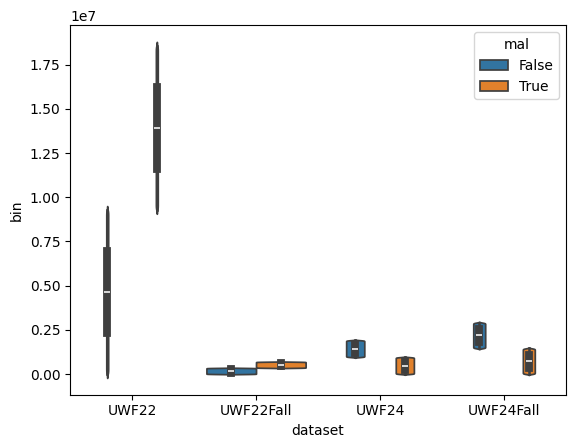

In [18]:
import seaborn as sns
sns.violinplot(data=all_datasets, x="dataset", y="bin", hue="mal")

In [5]:
df = pd.read_parquet("/data/datasets/UWF22/0.parquet")


In [7]:
import numpy as np

# Step 1: Create bins
df['bin'] = df['ts'] // 20

# Step 2: Create full bin range
full_bin_range = pd.Series(np.arange(df['bin'].min(), df['bin'].max() + 1), name='bin')

# Step 3: Merge to ensure all bins are present
df_full = pd.merge(full_bin_range.to_frame(), df, on='bin', how='left')

# Step 4: Compute batch_id for each bin (300 bins per batch)
df_full['batch_id'] = (df_full['bin'] - df_full['bin'].min()) // 300